In [2]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

## 1- Load Data

In [3]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = './dataset/Training/'
path_test = './dataset/Testing/'

img_size= 300


for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        # Read and resize images, then append to the training lists
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        # Read and resize images, then append to the testing lists        
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
# Convert lists to NumPy arrays
train_img = (np.array(train_img))
test_img = (np.array(test_img))

# Encode labels into numerical values for training and testing sets
train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [4]:
# Let's check the shape of our training & testing sets
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


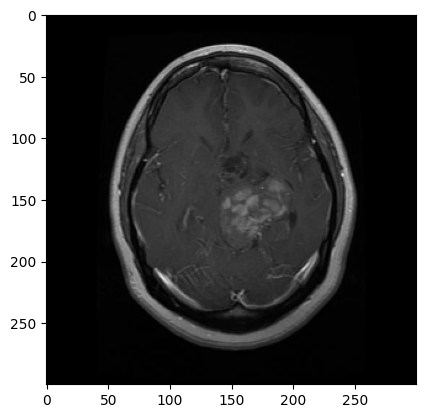

In [5]:
# Display the first image using Matplotlib
plt.imshow(train_img[0])
plt.show()

## Augmentation des images

In [6]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

#### `Exemple d'une image augmentée`

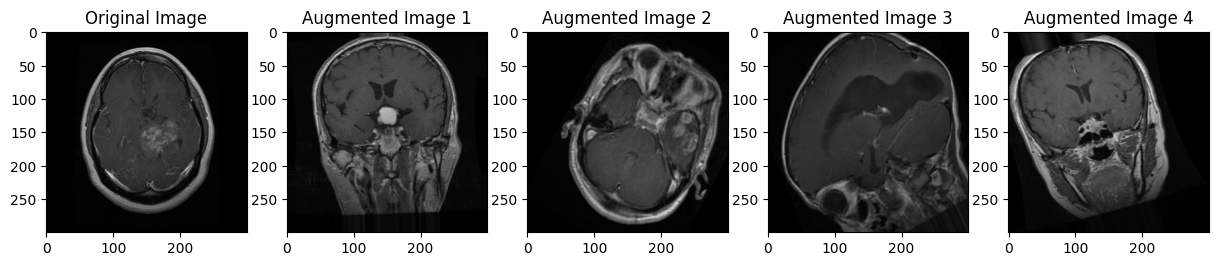

In [7]:
# Generate a batch of 4 augmented images using the data generator
augmented_images = img_datagen.flow(train_img, batch_size=4)

# Display the original and augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Adjusted the number of subplots for 5 images

# Original image
axes[0].imshow(train_img[0])
axes[0].set_title('Original Image')

# Display the augmented images in the batch
for i in range(1, 5):
    augmented_image = augmented_images.next()[0].astype('uint8')
    axes[i].imshow(augmented_image)
    axes[i].set_title(f'Augmented Image {i}')

plt.show()

In [8]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

## Data Visualisation

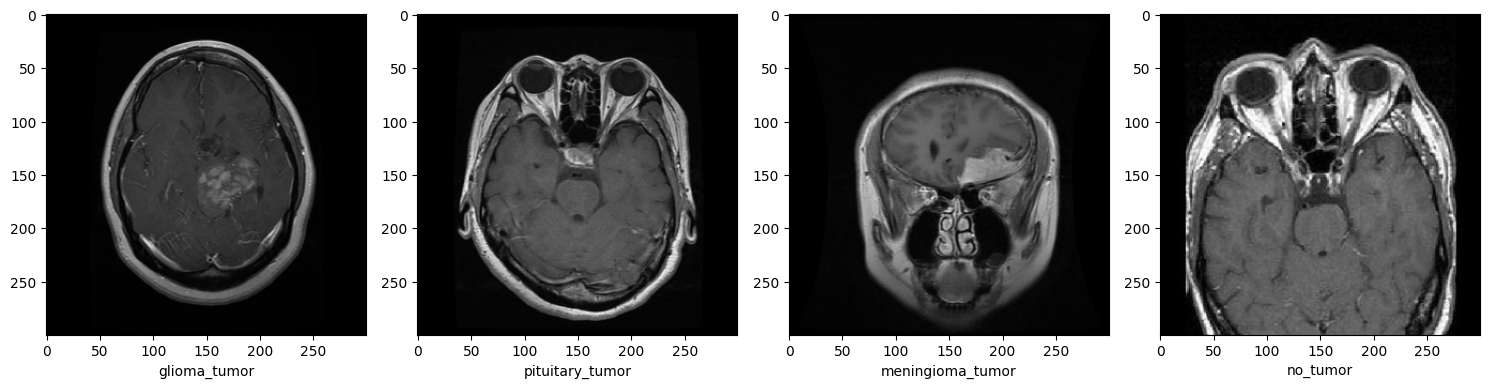

In [9]:
plt.figure(figsize=(15, 5))

unique_labels = set(train_labels)

for i, label in enumerate(unique_labels):

    index = train_labels.index(label)
    
    plt.subplot(1, len(unique_labels), i+1)
    plt.imshow(train_img[index])
    plt.xlabel(label)

plt.tight_layout()
plt.show()

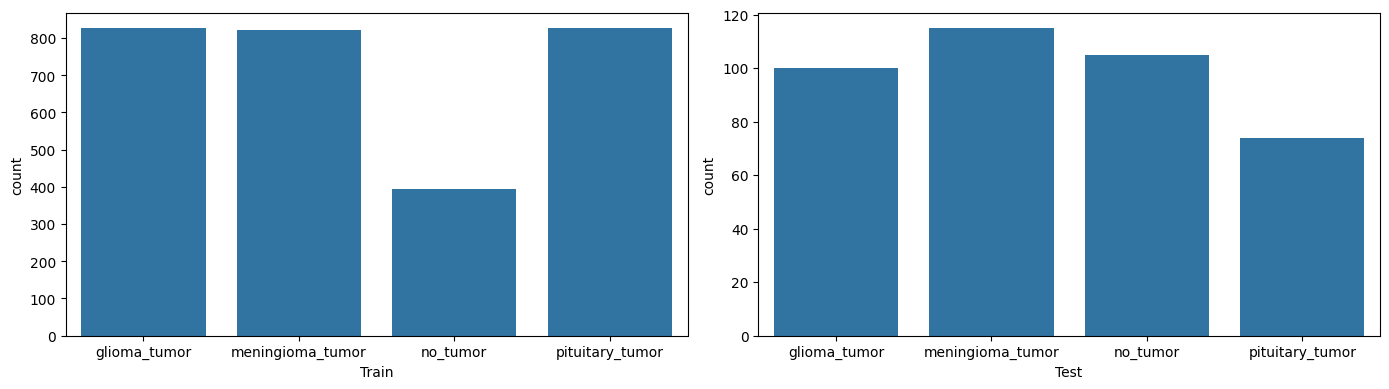

In [10]:
plt.figure(figsize = (14,4));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

plt.tight_layout()
plt.show()

In [11]:
model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

**Conv2D Layers:**
These layers apply convolution operations to the input. They employ a specified number of filters (32 or 64) and a kernel size of (5, 5) or (3, 3). The activation function used is Rectified Linear Unit (ReLU), and 'same' padding is applied to maintain consistent spatial dimensions.

**MaxPool2D Layers:**
These layers perform max-pooling, effectively reducing the spatial dimensions of the feature maps by selecting the maximum value in each pooling window.

**Flatten Layer:**
This layer serves to flatten the 3D output into a 1D vector, facilitating the smooth transition from convolutional layers to dense layers.

**Dense Layers:**
These fully connected layers are densely packed. The first layer boasts 128 units and employs the ReLU activation function. The second (output) layer consists of 4 units (equal to the number of classes) and uses the sigmoid activation function, indicative of a multi-class classification problem.

**Dropout Layer:**
This layer strategically drops a fraction of input units during training to prevent overfitting. A dropout rate of 0.5 is specified.

In [12]:
history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_labels)), validation_split=0.1, epochs =20, verbose=1, batch_size=32)

Epoch 1/20
81/81 [==============================] - 56s 644ms/step - loss: 5.4592 - accuracy: 0.4425 - val_loss: 1.6384 - val_accuracy: 0.2753
Epoch 2/20
81/81 [==============================] - 50s 617ms/step - loss: 0.9323 - accuracy: 0.5718 - val_loss: 0.8655 - val_accuracy: 0.7561
Epoch 3/20
81/81 [==============================] - 47s 575ms/step - loss: 0.8129 - accuracy: 0.6438 - val_loss: 1.3378 - val_accuracy: 0.4669
Epoch 4/20
81/81 [==============================] - 45s 560ms/step - loss: 0.6657 - accuracy: 0.7263 - val_loss: 1.1016 - val_accuracy: 0.5889
Epoch 5/20
81/81 [==============================] - 49s 602ms/step - loss: 0.5765 - accuracy: 0.7607 - val_loss: 0.8407 - val_accuracy: 0.7073
Epoch 6/20
81/81 [==============================] - 47s 580ms/step - loss: 0.4858 - accuracy: 0.8053 - val_loss: 0.8238 - val_accuracy: 0.6794
Epoch 7/20
81/81 [==============================] - 46s 568ms/step - loss: 0.3902 - accuracy: 0.8386 - val_loss: 0.5196 - val_accuracy: 0.7875

### NB

Adding padding here to preserve the image shape

Adding maxpool layer to get those pixels which have the highest intensity. Reduces the image size by 2.

Took filters of 77 as image size if 300 300 thus it would help it to learn better.

Taken a dropout layer, to avoid overfitting.

The image from data generator is of type 'uint8', you need to type cast it to 'float32'.

In [13]:
model.layers[0].get_weights()[0].shape

(5, 5, 3, 32)

In [14]:
test_loss, test_accuracy = model.evaluate(tf.cast(test_img, tf.float32), np.array(pd.get_dummies(test_labels)))

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

13/13 [==============================] - 2s 149ms/step - loss: 7.3218 - accuracy: 0.7437
Test Loss: 7.3218
Test Accuracy: 74.37%
